In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler

In [2]:
!python -V

Python 3.7.3


In [3]:
dataset = pd.read_csv("/home/jagadeesh/DS/FB.csv",parse_dates=['Date'],index_col='Date')

In [4]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [5]:
def make_dataset(array,time_steps):

    x = []
    y = []

    for i in range(time_steps,len(array)):
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

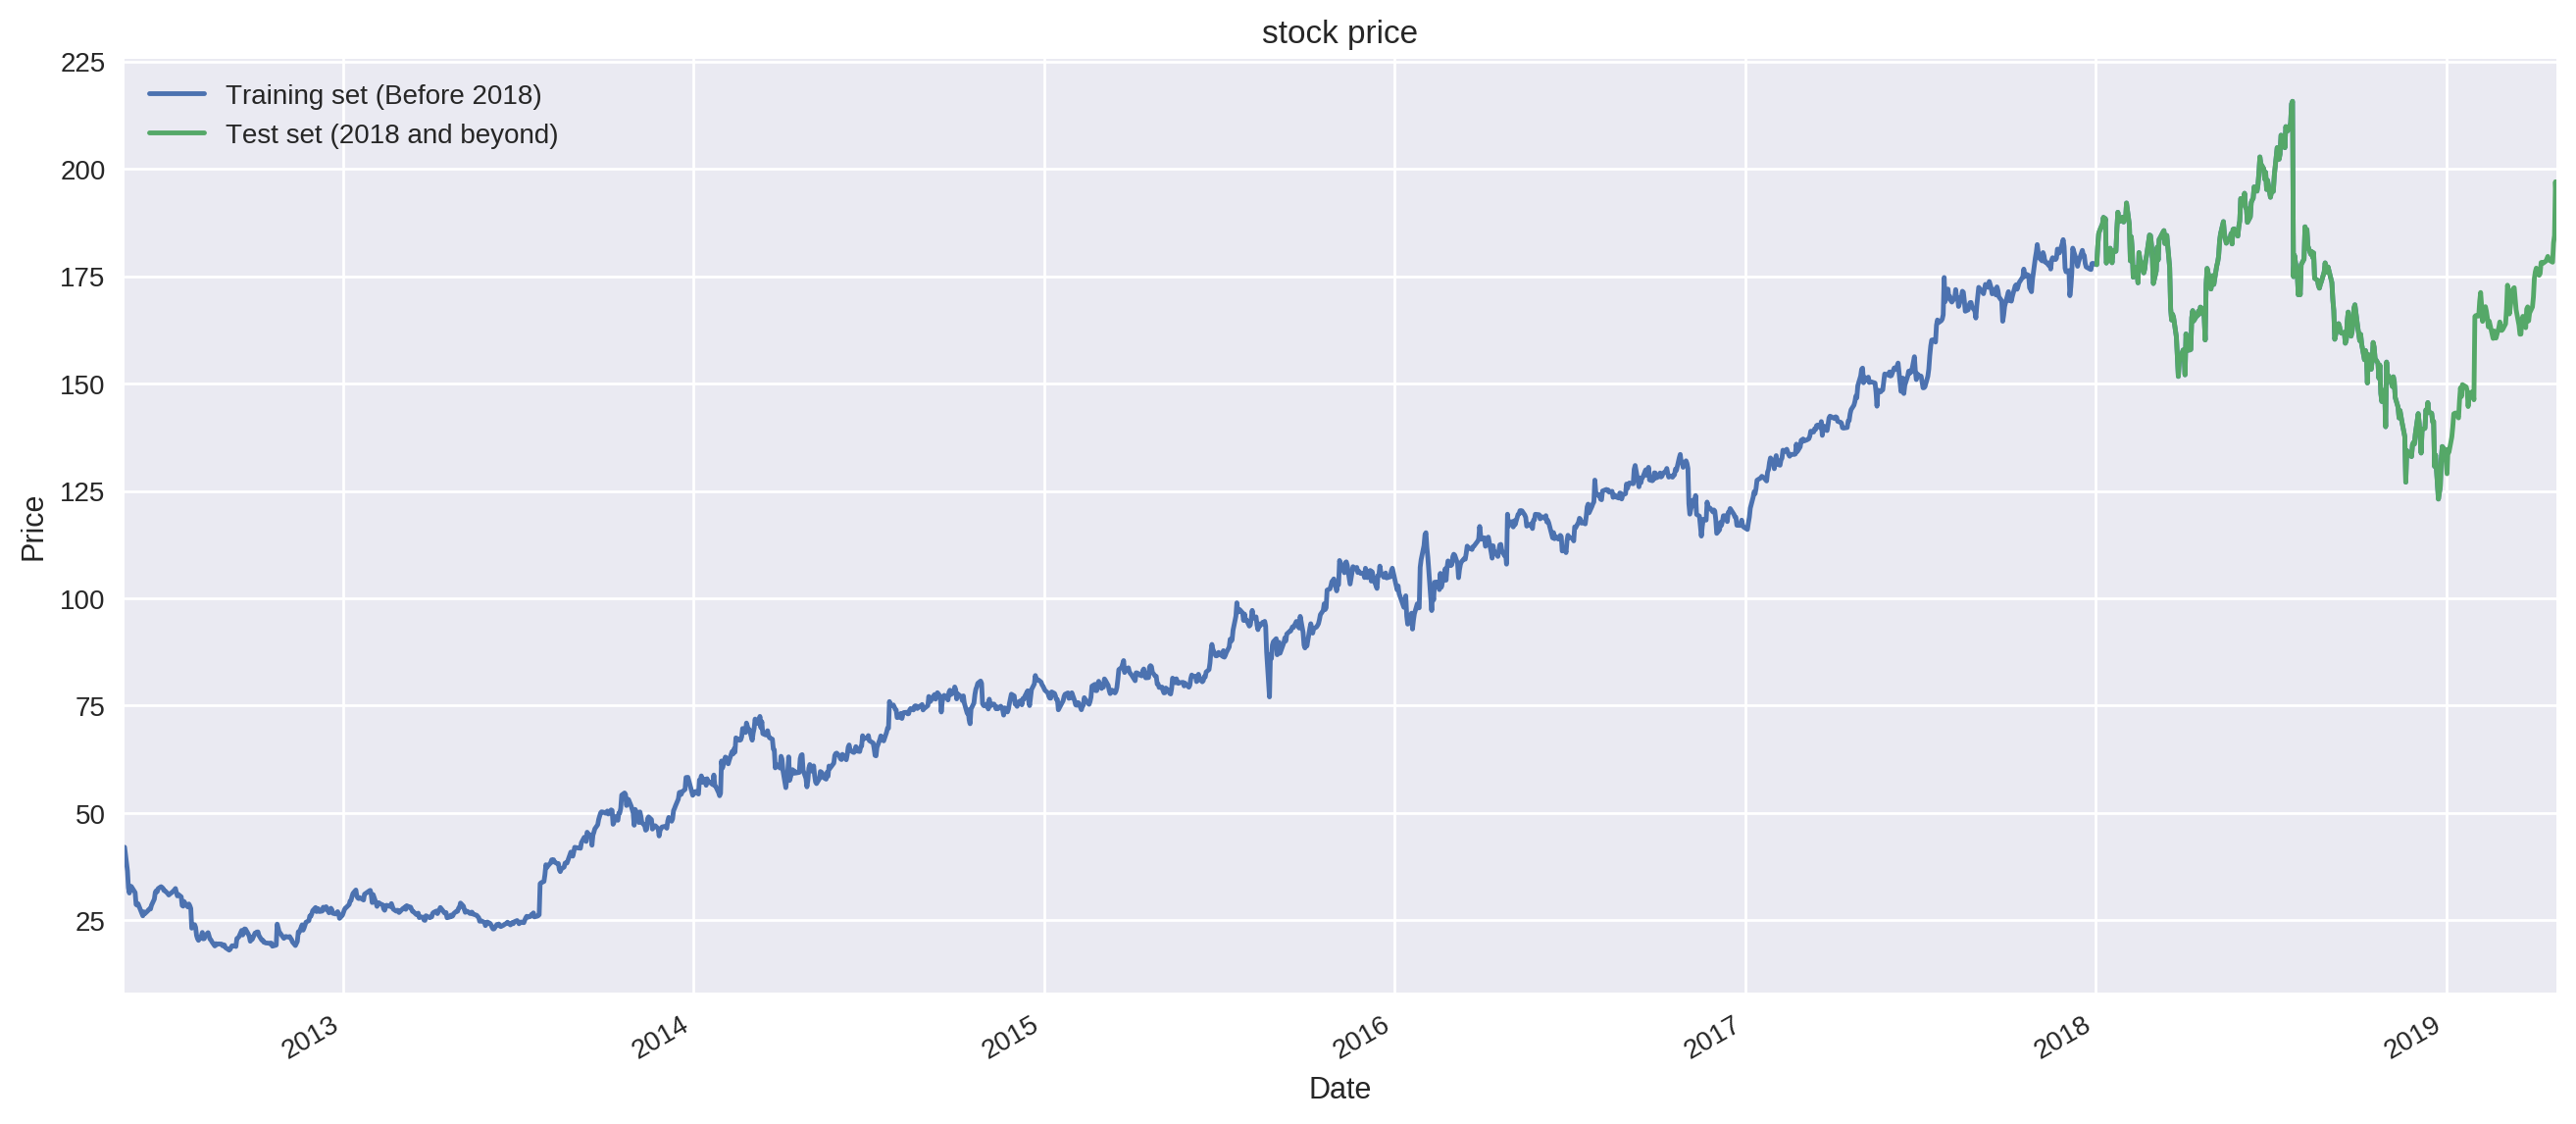

In [6]:
plt.figure(dpi=200,figsize=(16,7))
dataset["Open"][:'2018'].plot(legend=True)
dataset["Open"]['2018':].plot(legend=True)
plt.legend(['Training set (Before 2018)','Test set (2018 and beyond)'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [7]:
train = dataset[:"2018"]["Open"].values


scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train.reshape(-1,1))

trn_x,trn_y = make_dataset(train,60)

## The three dimensions of this input are:

* **Samples**. One sequence is one sample. A batch is comprised of one or more samples.
* **Time Steps**. One time step is one point of observation in the sample.
* **Features**. One feature is one observation at a time step.

In [8]:
trn_x = trn_x.reshape(-1,60,1)

### Model Architecture

* LSTM(50) x 3 layers with 0.2 Dropout.
* Dense(50,1)

In [9]:
import mxnet as mx
from mxnet import nd
import mxnet.gluon as G

class Net(G.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            
            self.lstm = G.rnn.LSTM(120,3,dropout=0.2)
            self.out = G.nn.Dense(1)
            
    def forward(self,x):
        
        x = self.lstm(x)
        x = self.out(x)
        
        return x
    
Model = Net()
print(Model)

Net(
  (lstm): LSTM(None -> 120, TNC, num_layers=3, dropout=0.2)
  (out): Dense(None -> 1, linear)
)


In [10]:
device = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)
Model.initialize(mx.init.Xavier(), ctx=device)

In [11]:
trainer = G.Trainer(
    params=Model.collect_params(),
    optimizer='adam',
    optimizer_params={'learning_rate': 0.01},
)

In [12]:
loss_function = G.loss.L2Loss()
mse = mx.metric.MSE()

In [13]:
def reset_metrics():
    mse.reset()
    
    
def get_loss_acc(iterator,Model,loss_function):
    
    loss_of_batches = []
    
    for batch in iterator:
        x = batch.data[0].as_in_context(device)
        y = batch.label[0].as_in_context(device)
    
        output = Model(x)
        loss_function.update(y,output)
        
        _,loss = loss_function.get()
        
        loss_of_batches.append(loss)
        reset_metrics()
    

    return np.mean(loss_of_batches)

In [14]:
from mxnet import autograd

EPOCHS = 1350

trn_loss = []

train_iter = mx.io.NDArrayIter(trn_x, trn_y, 1000, shuffle=True)

for epoch in range(EPOCHS):
    
    for trn_batch in train_iter:

        x = trn_batch.data[0].as_in_context(device)
        y = trn_batch.label[0].as_in_context(device)
        
        with autograd.record():
            y_pred = Model(x)
            loss = loss_function(y_pred, y)
        
        #backprop
        loss.backward()
        
        #Optimize!
        trainer.step(batch_size=trn_x.shape[0])
        
    train_iter.reset()
    
    """ Calculate train metrics """
    loss = get_loss_acc(train_iter,Model,mse)
    trn_loss.append(loss)
    train_iter.reset()
    if epoch % 10 == 0:
        print("epoch: {} | trn_loss: {:.4f}".format(epoch+1,trn_loss[-1]))

epoch: 1 | trn_loss: 1.8618
epoch: 11 | trn_loss: 0.0748
epoch: 21 | trn_loss: 0.0321
epoch: 31 | trn_loss: 0.0045
epoch: 41 | trn_loss: 0.0025
epoch: 51 | trn_loss: 0.0019
epoch: 61 | trn_loss: 0.0018
epoch: 71 | trn_loss: 0.0017
epoch: 81 | trn_loss: 0.0022
epoch: 91 | trn_loss: 0.0015
epoch: 101 | trn_loss: 0.0015
epoch: 111 | trn_loss: 0.0016
epoch: 121 | trn_loss: 0.0015
epoch: 131 | trn_loss: 0.0017
epoch: 141 | trn_loss: 0.0022
epoch: 151 | trn_loss: 0.0018
epoch: 161 | trn_loss: 0.0013
epoch: 171 | trn_loss: 0.0015
epoch: 181 | trn_loss: 0.0017
epoch: 191 | trn_loss: 0.0014
epoch: 201 | trn_loss: 0.0012
epoch: 211 | trn_loss: 0.0017
epoch: 221 | trn_loss: 0.0010
epoch: 231 | trn_loss: 0.0011
epoch: 241 | trn_loss: 0.0009
epoch: 251 | trn_loss: 0.0015
epoch: 261 | trn_loss: 0.0009
epoch: 271 | trn_loss: 0.0008
epoch: 281 | trn_loss: 0.0009
epoch: 291 | trn_loss: 0.0012
epoch: 301 | trn_loss: 0.0012
epoch: 311 | trn_loss: 0.0007
epoch: 321 | trn_loss: 0.0007
epoch: 331 | trn_loss

## Validation

* Test our model on whole data including test set(2018 and beyond)

In [15]:
total = dataset['Open'].values
total_scaled = scaler.transform(total.reshape(-1,1))

total_x,total_y = make_dataset(total_scaled,60)

total_x = nd.array(total_x)

pred = Model(total_x.as_in_context(device))
predictions = []

for p in pred.asnumpy():
    predictions.append(p[0])

predictions = np.array(predictions).reshape(-1,1)

In [16]:
predicted = scaler.inverse_transform(predictions)

In [17]:
#make a dataset with real and predicted values.

infered = pd.DataFrame(dataset['Open'].iloc[60:])
infered['Open_Predicted'] = predicted

In [18]:
infered.tail()

,Open,Open_Predicted
Date,,
2019-04-22,178.250000,177.653885
2019-04-23,182.740005,177.378662
2019-04-24,184.490005,178.699051
2019-04-25,196.979996,180.131287
2019-04-26,192.500000,185.419006


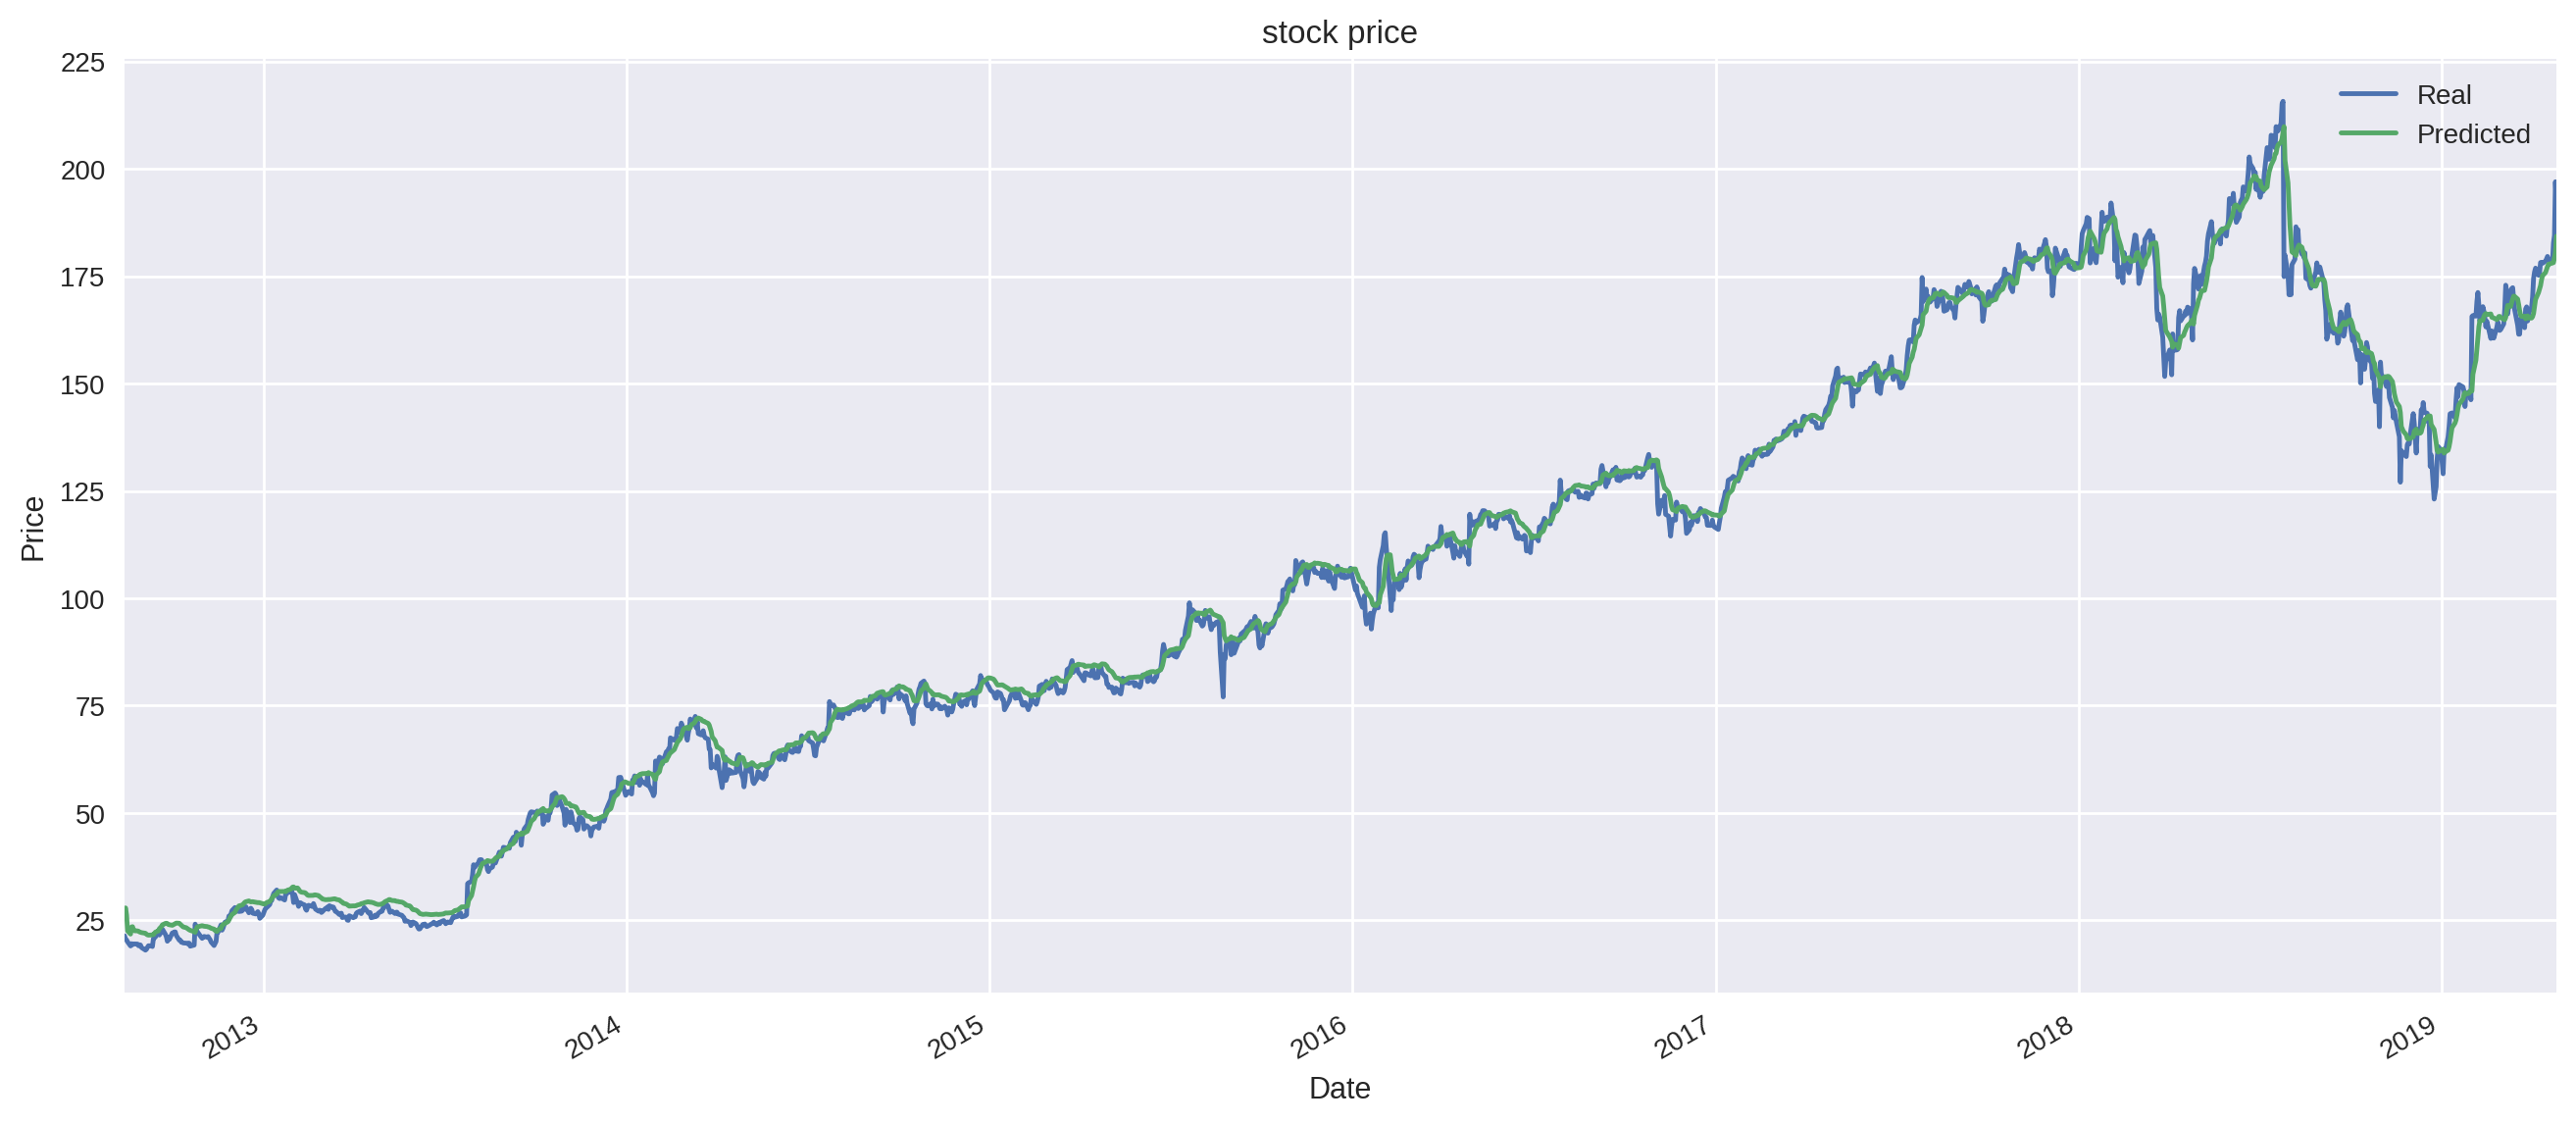

In [19]:
plt.figure(dpi=200,figsize=(16,7))
infered["Open"].plot(legend=True)
infered["Open_Predicted"].plot(legend=True)
plt.legend(['Real','Predicted'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(dataset['Open'].iloc[60:].values,predicted)
print("RMSE:", np.sqrt(mse))

RMSE: 3.45908316003704
